In [129]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge

from sklearn.linear_model import LassoCV, Lasso
import numpy as np
from sklearn.datasets import make_regression

from csv_reader import *
from csv_setup import *

bike_sharing_df = get_bike_sharing_df_clean()
plt.rcParams.update({'font.size': 18})

In [130]:
def rmsle(y_log, y0_log):
    return np.sqrt(np.mean(np.square(y_log - y0_log)))

In [131]:
# Train and test data preperation
# We split the data first, then we take the log of the cnt, which represents the number of bikes on a given day

scaler = StandardScaler()

# Count variable that we are going to be predicting
Y = bike_sharing_df.cnt
# Features that we are going to be fitting
X = bike_sharing_df.loc[:].drop(columns=["cnt"])

# Split the data
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 1)

# log of each of the cnt
# this will normalize the variable that we are trying to predict
y_train_log = y_train.apply(lambda x:np.log1p(x))
y_test_log = y_test.apply(lambda x:np.log1p(x))

# y_train_log = y_train
# y_test_log = y_test

preScale_X_train = X_train
preScale_X_test = x_test


X_train = scaler.fit_transform(X_train)
x_test = scaler.fit_transform(x_test)


# y_test = y_test.reset_index().drop('index',axis = 1)
# y_train = y_train.reset_index().drop('index',axis = 1)

parameters = {
         'lasso__alpha':np.logspace(0, 9, 100),
    }


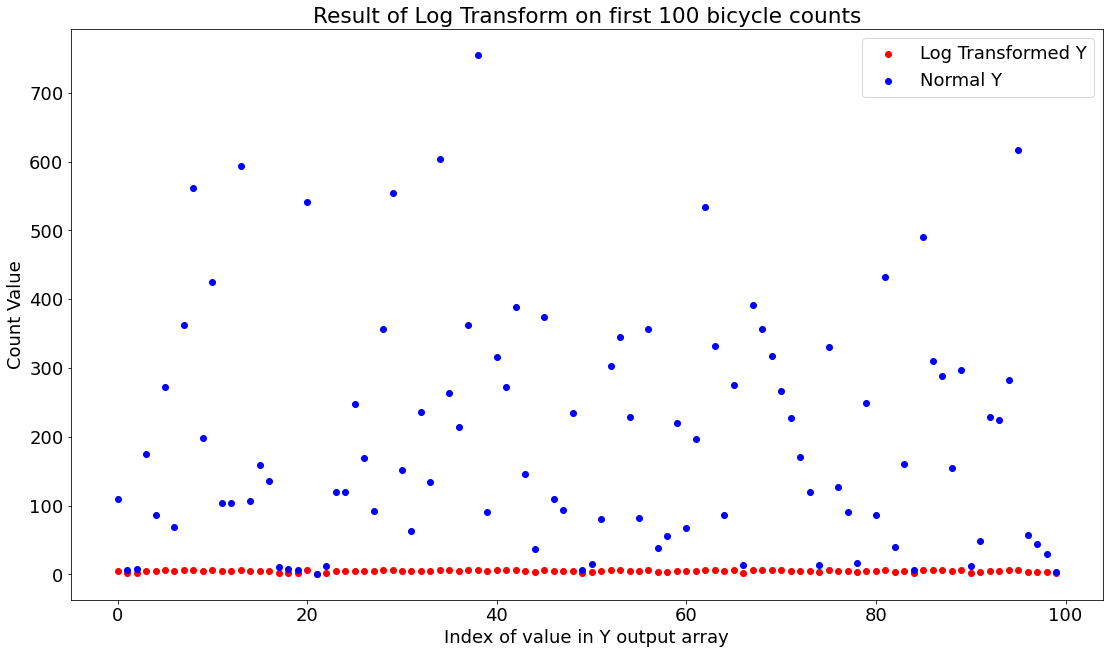

In [132]:
plt.figure()
plt.gcf().set_size_inches(18.5, 10.5)
xvalues = []
i = 0
for a in range(0, 100):
    xvalues.append(a)
    i = i+1

plt.scatter(xvalues,y_train_log[:100],color="red", label="Log Transformed Training")
plt.scatter(xvalues,y_train[:100],color="blue", label="Normal Training")
ax = plt.gca()

ax.legend(("Log Transformed Y", "Normal Y"))
plt.xlabel('Index of value in Y output array')
plt.ylabel('Count Value');
plt.title('Result of Log Transform on first 100 bicycle counts')
plt.show()

7445     20
13512     5
6158      4
13205    10
1616     20
         ..
10955    15
17289     6
5192      6
12172     9
235       2
Name: hr, Length: 11643, dtype: int64


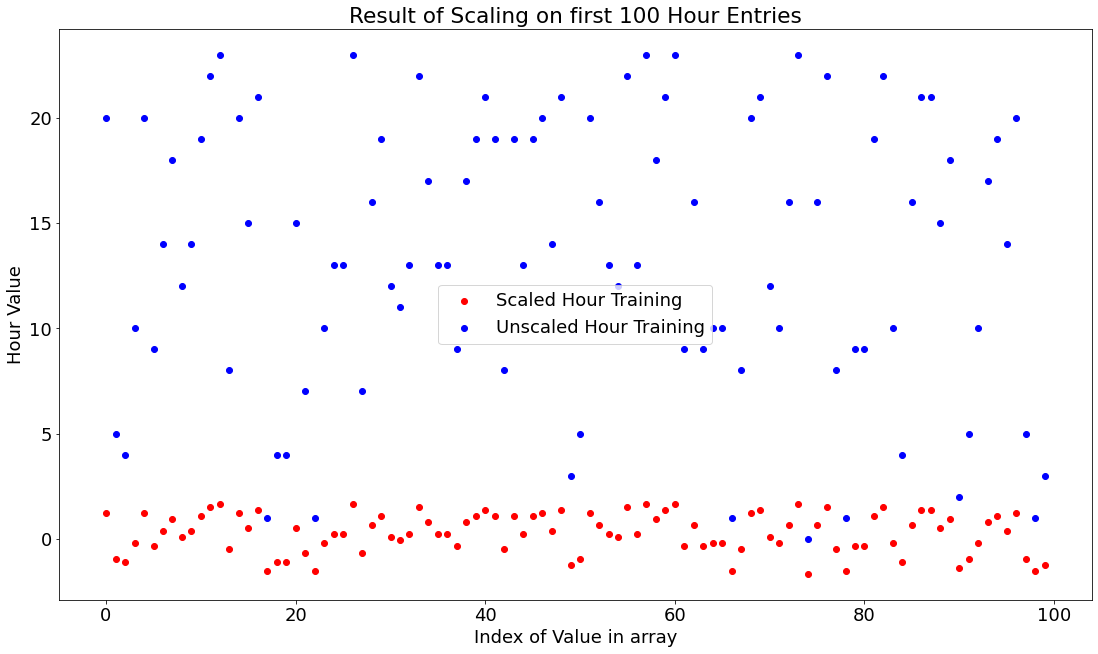

In [133]:
plt.figure()
plt.gcf().set_size_inches(18.5, 10.5)
xvalues = []
i = 0
test = []

print(preScale_X_train['hr'])
        
for a in range(0, 100):
    xvalues.append(a)
    i = i+1
plt.scatter(xvalues,X_train[:,0][:100],color="red", label="Log Transformed Training")
plt.scatter(xvalues,preScale_X_train['hr'][:100],color="blue", label="Normal Training")
ax = plt.gca()

ax.legend(("Scaled Hour Training ", "Unscaled Hour Training"))
plt.xlabel('Index of Value in array')
plt.ylabel('Hour Value');
plt.title('Result of Scaling on first 100 Hour Entries')
plt.show()

In [134]:
# This function uses the original count values
# The MSE will be extremely high

def LassoNormal(x_train, y_train):
    # 0-9 to show all iterations that are done
    # Now we are using just the neg_mean_squared_error to find the best coeff
    pipe = make_pipeline(scaler, Lasso(fit_intercept=True))
    gs = GridSearchCV(pipe,parameters, scoring='neg_mean_squared_error', cv=5)
    gs.fit(X_train,y_train)
    return gs

In [135]:
def LassoLog(x_train, y_train):
    # Here we are cross validating as well as fitting the model
    # We are using the neg_mean_squared_log_error to find the best alpha
    pipe = make_pipeline(scaler, Lasso(fit_intercept=True))
    gs = GridSearchCV(pipe,parameters, scoring='neg_mean_squared_log_error', cv=5)
    gs.fit(X_train,y_train_log)
    return gs


In [136]:
gsLasso = LassoNormal(X_train, y_train)
gsLassoLog = LassoLog(X_train, y_train_log)

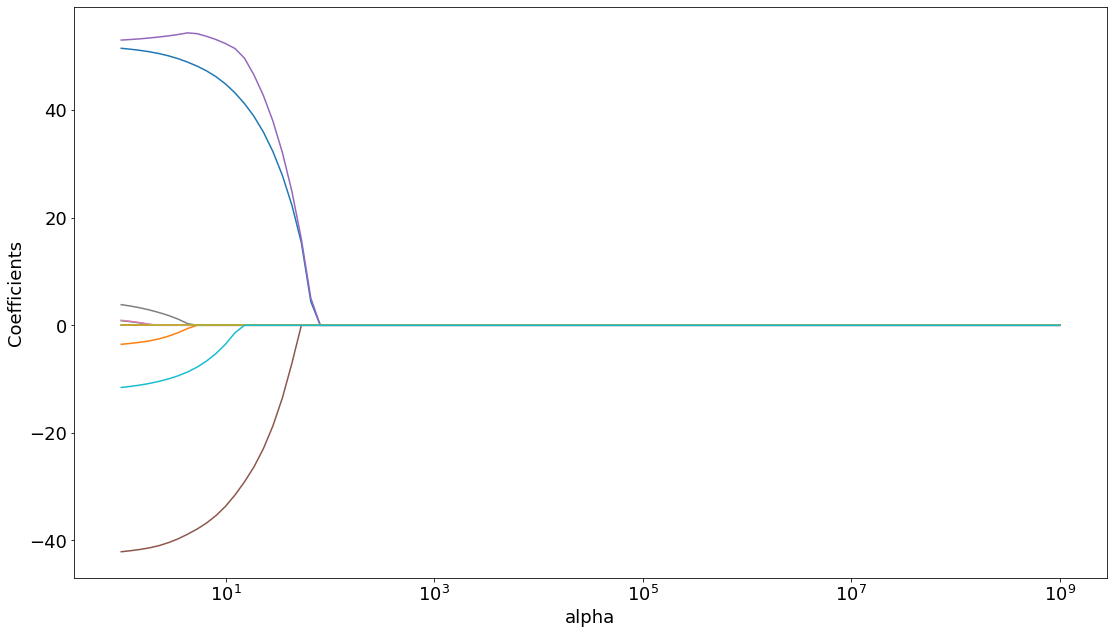

In [137]:


scaler = StandardScaler()
lasso = Lasso(normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)
coefs = []
# print(pipe.get_params().keys()) #reports input names can set (look for the hyper-parameters)
parameters = {'lasso__alpha':np.logspace(0, 9, 100)}
# model = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)
# model.fit(X_train,y_train)
for a in  parameters['lasso__alpha']:
    pipe.set_params(lasso__alpha=a)
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['lasso'].coef_)

plt.figure()
plt.gcf().set_size_inches(18.5, 10.5)

ax = plt.gca()
ax.plot(np.logspace(0, 9, 100), coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients');

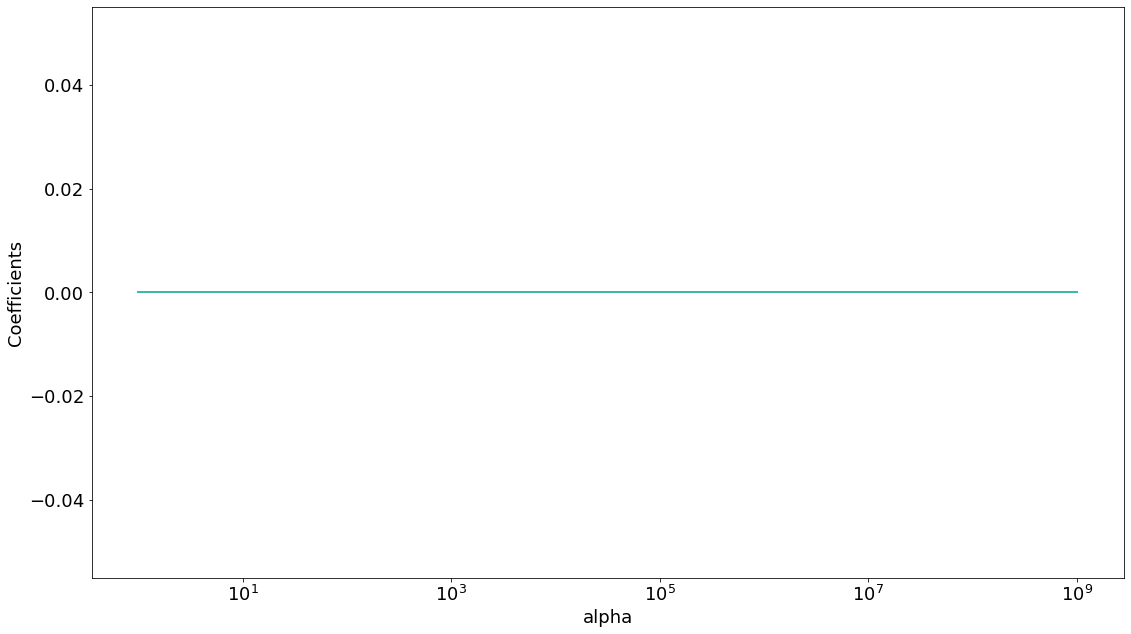

In [138]:
scaler = StandardScaler()
lasso = Lasso(normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)
coefs = []
# print(pipe.get_params().keys()) #reports input names can set (look for the hyper-parameters)
parameters = {'lasso__alpha':np.logspace(0, 9, 100)}
# model = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)
# model.fit(X_train,y_train)
for a in  parameters['lasso__alpha']:
    pipe.set_params(lasso__alpha=a)
    pipe.fit(X_train, y_train_log)
    coefs.append(pipe.named_steps['lasso'].coef_)

plt.figure()
ax = plt.gca()
ax.plot(np.logspace(0, 9, 100), coefs)
ax.set_xscale('log')
plt.gcf().set_size_inches(18.5, 10.5)


plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients');

In [139]:
print("Best alpha Log: " + str(gsLassoLog.best_params_['lasso__alpha']))
print("Best coeff Log: " + str(gsLassoLog.best_estimator_.named_steps['lasso'].coef_))

print("\nBest alpha Normal: " + str(gsLasso.best_params_['lasso__alpha']))
print("Best coeff Normal: " + str(gsLasso.best_estimator_.named_steps['lasso'].coef_))



Best alpha Log: 1.0
Best coeff Log: [ 0. -0.  0. -0.  0. -0.  0.  0. -0. -0.]

Best alpha Normal: 1.0
Best coeff Normal: [ 51.50057924  -3.53397397   0.86020109  -0.          53.03101212
 -42.10661726   0.9289991    3.83850382  -0.         -11.56141201]


In [140]:
# Average of Y's
np.mean(y_train_log)

4.5717683471239114

In [141]:
print('\nCoefficients  [ridge] Log')

yvalues1 = gsLassoLog.best_estimator_.named_steps['lasso'].coef_
for i in range(0,10):
    print('   Feature %f:  %.2f'%(i,\
                    yvalues1[i]))

print('\nCoefficients  [ridge] Normal')

yvalues2 = gsLasso.best_estimator_.named_steps['lasso'].coef_
for i in range(0,10):
    print('   Feature %f:  %.2f'%(i,\
                    yvalues2[i]))
xvalues = []
xvalues = [1,2,3,4,5,6,7,8,9,10]
   


Coefficients  [ridge] Log
   Feature 0.000000:  0.00
   Feature 1.000000:  -0.00
   Feature 2.000000:  0.00
   Feature 3.000000:  -0.00
   Feature 4.000000:  0.00
   Feature 5.000000:  -0.00
   Feature 6.000000:  0.00
   Feature 7.000000:  0.00
   Feature 8.000000:  -0.00
   Feature 9.000000:  -0.00

Coefficients  [ridge] Normal
   Feature 0.000000:  51.50
   Feature 1.000000:  -3.53
   Feature 2.000000:  0.86
   Feature 3.000000:  -0.00
   Feature 4.000000:  53.03
   Feature 5.000000:  -42.11
   Feature 6.000000:  0.93
   Feature 7.000000:  3.84
   Feature 8.000000:  -0.00
   Feature 9.000000:  -11.56


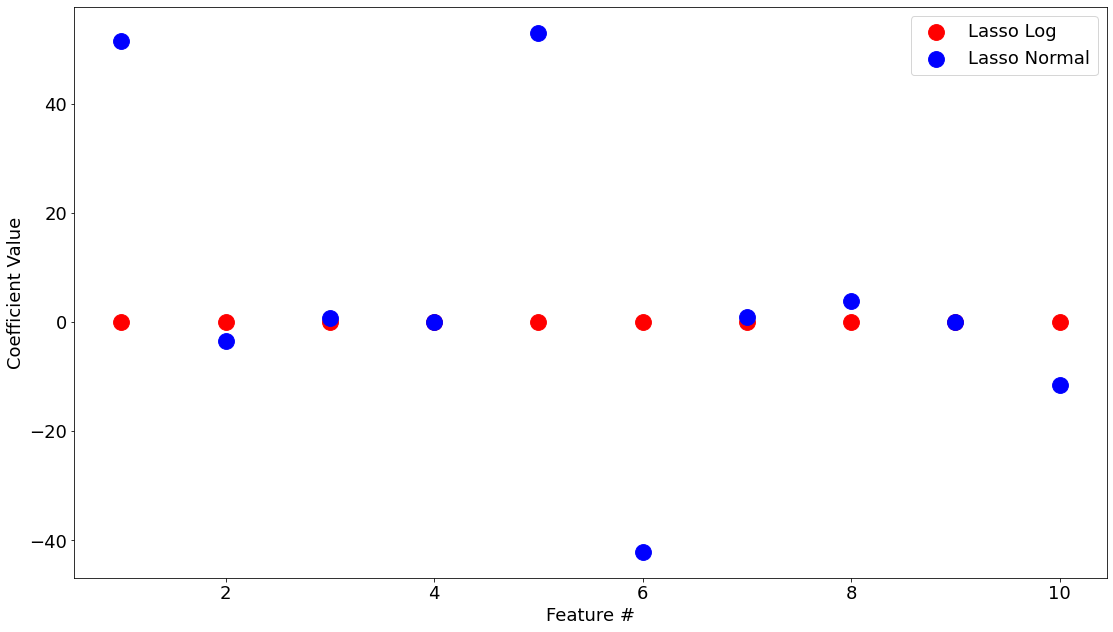

In [142]:
# This is a plot showing the difference between the coefficient values.
# The largest difference being between the value of the coefficients for features 5 and 6

plt.figure()
plt.gcf().set_size_inches(18.5, 10.5)

plt.scatter(xvalues,yvalues1,s=250,color="red", label="Lasso Log")
plt.scatter(xvalues,yvalues2,s=250,color="blue", label="Lasso Normal")
ax = plt.gca()

ax.legend(("Lasso Log", "Lasso Normal"))
plt.xlabel('Feature #')
plt.ylabel('Coefficient Value');
plt.show()

In [143]:
y_pred = gsLassoLog.predict(x_test)

mse_test_using_lasso = mean_squared_error(y_test_log,y_pred)
print('\nTest set MSE using Log Lasso coefficients: %.2f'%mse_test_using_lasso)
print('Test set RMLSE using Log Lasso coefficients %.2f'%rmsle(y_test_log, y_pred))


# One reason for the MSE being unreasonably high here is the high variance in the data
# Compared to that of the log transformed MSE of the Log Ridge
y_pred = gsLasso.predict(x_test)
mse_test_using_lasso = mean_squared_error(y_test,y_pred)
print('\nTest set MSE using Normal Lasso coefficients: %.2f'%mse_test_using_lasso)
print('Once again, we cannot use the Normal Lasso coefficients to calculate RMLSE because it predicts negative numbers')


Test set MSE using Log Lasso coefficients: 2.04
Test set RMLSE using Log Lasso coefficients 1.43

Test set MSE using Normal Lasso coefficients: 22858.81
Once again, we cannot use the Normal Lasso coefficients to calculate RMLSE because it predicts negative numbers


In [144]:
lm = gsLassoLog

y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(x_test)


print('R squared statistic for Log Ridge')
print('Train Score: ')
print(r2_score(y_train_log, y_train_pred))

print('\nTest Score: ')
print(r2_score(y_test_log, y_test_pred))

R squared statistic for Log Ridge
Train Score: 
0.0

Test Score: 
-3.979437950607512e-05


In [145]:
lm = gsLasso

y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(x_test)

print('R squared statistic for Normal Ridge')

print('Train Score: ')
print(r2_score(y_train, y_train_pred))

print('\nTest Score: ')
print(r2_score(y_test, y_test_pred))

R squared statistic for Normal Ridge
Train Score: 
0.32989796838281615

Test Score: 
0.330631466869188
